# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [4]:
geo_data0 = pd.read_csv('datasets/geo_data_0.csv')
geo_data1 = pd.read_csv('datasets/geo_data_1.csv')
geo_data2 = pd.read_csv('datasets/geo_data_2.csv')

In [5]:
geo_data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
geo_data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
geo_data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
geo_data0 = geo_data0.set_index('id')
geo_data1 = geo_data1.set_index('id')
geo_data2 = geo_data2.set_index('id')

### Дубликаты

In [9]:
geo_data0.duplicated().sum()

0

In [10]:
geo_data0.index.duplicated(keep=False).sum()

20

In [11]:
geo_data0 = geo_data0[~geo_data0.index.duplicated(keep='first')]

In [12]:
geo_data0.index.duplicated(keep=False).sum()

0

In [13]:
geo_data1.duplicated().sum()

0

In [14]:
geo_data1.index.duplicated(keep=False).sum()

8

In [15]:
geo_data1 = geo_data1[~geo_data1.index.duplicated(keep='first')]
geo_data1.index.duplicated(keep=False).sum()

0

In [16]:
geo_data2.duplicated().sum()

0

In [17]:
geo_data2.index.duplicated(keep=False).sum()

8

In [18]:
geo_data2 = geo_data2[~geo_data2.index.duplicated(keep='first')]
geo_data2.index.duplicated(keep=False).sum()

0

### Пропуски

In [19]:
geo_data0.isnull().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [20]:
geo_data1.isnull().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [21]:
geo_data2.isnull().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

### Типы данных

In [22]:
geo_data0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float64
 1   f1       99990 non-null  float64
 2   f2       99990 non-null  float64
 3   product  99990 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


In [23]:
geo_data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


In [24]:
geo_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 5.8+ MB


### Матрицы корреляции

In [25]:
corr = geo_data0.corr('spearman')
corr.style.background_gradient(cmap='RdYlGn')

,f0,f1,f2,product
f0,1.000000,-0.471379,-0.002739,0.128379
f1,-0.471379,1.000000,0.001440,-0.181136
f2,-0.002739,0.001440,1.000000,0.486370
product,0.128379,-0.181136,0.486370,1.000000


In [26]:
corr = geo_data1.corr('spearman')
corr.style.background_gradient(cmap='RdYlGn')

,f0,f1,f2,product
f0,1.000000,0.182247,-0.002024,-0.122901
f1,0.182247,1.000000,-0.003674,-0.033906
f2,-0.002024,-0.003674,1.000000,0.975604
product,-0.122901,-0.033906,0.975604,1.000000


В первом регионе признак f2 сильно коррелирует с целевой переменной product

In [27]:
corr = geo_data2.corr('spearman')
corr.style.background_gradient(cmap='RdYlGn')

,f0,f1,f2,product
f0,1.000000,0.002471,0.000046,-0.002453
f1,0.002471,1.000000,0.000349,-0.001508
f2,0.000046,0.000349,1.000000,0.448459
product,-0.002453,-0.001508,0.448459,1.000000


In [28]:
def hist(df):
    columns = df.columns
    for col in columns:
        plt.hist(df[col], color='#ff7f50')
        plt.title(col)
        plt.show()

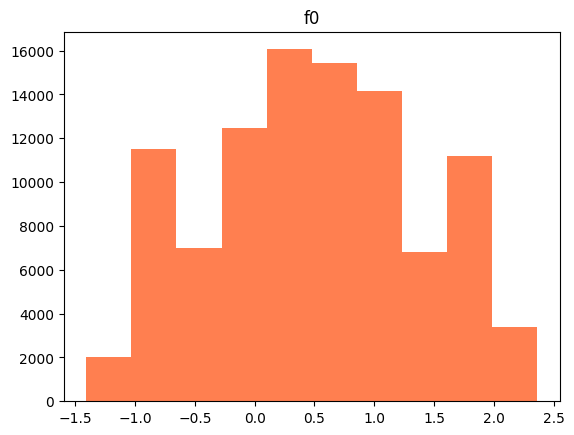

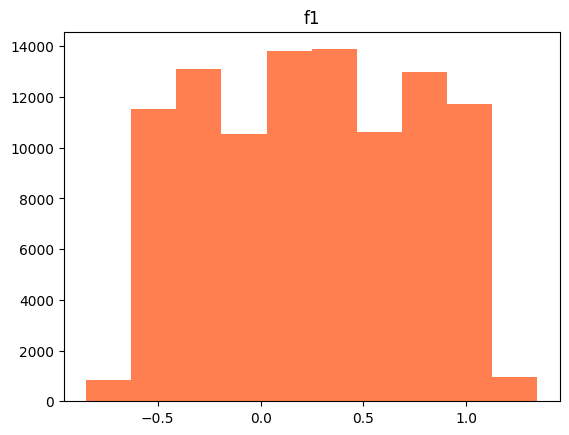

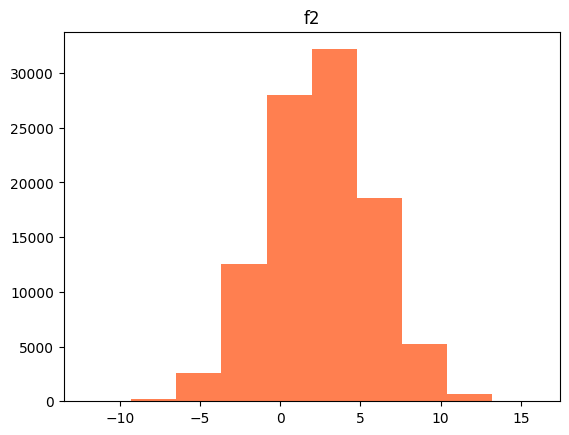

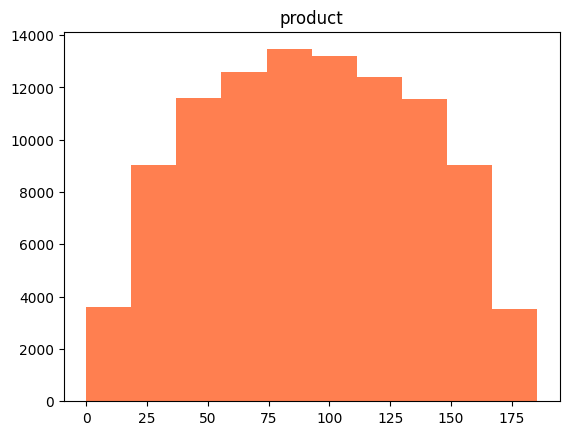

In [29]:
hist(geo_data0)

В регионе 0 целевой признак имеет нормальное распределение. Распределение f1 близко к равномерному

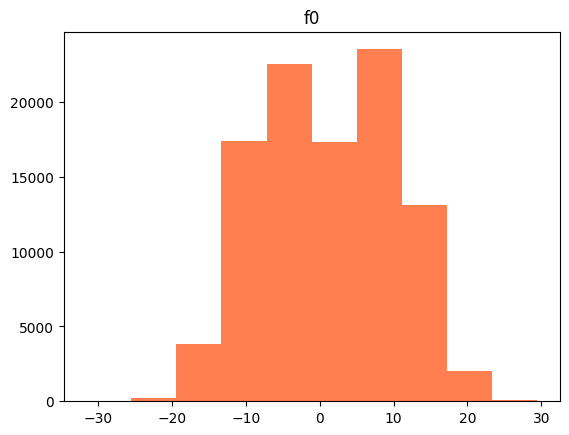

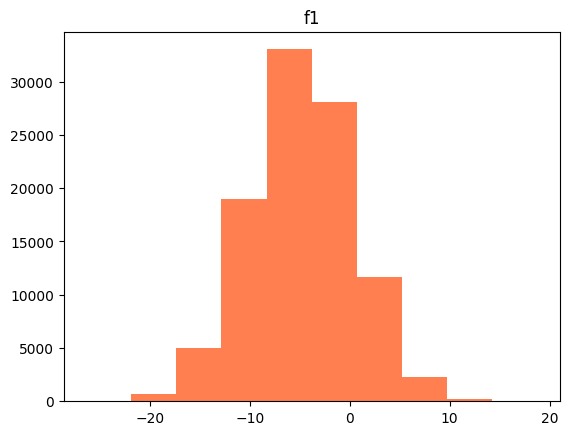

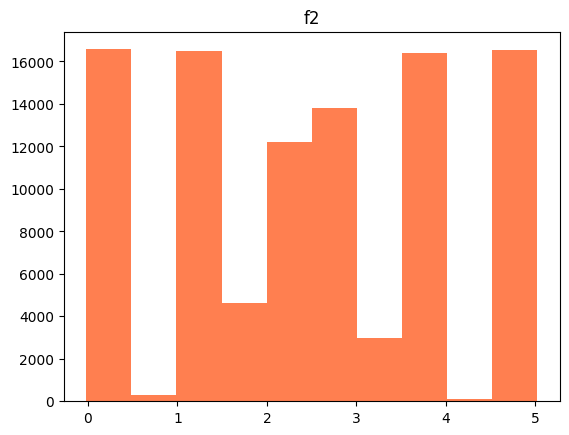

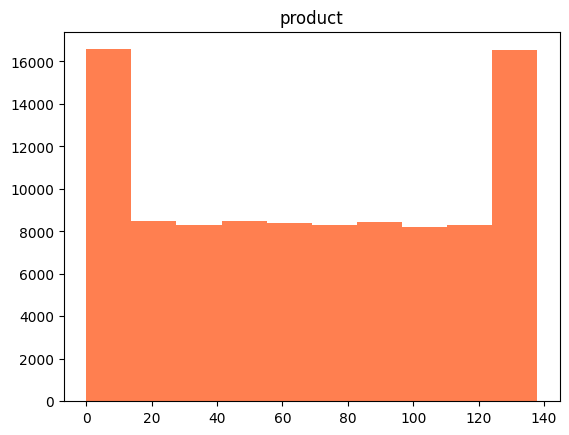

In [30]:
hist(geo_data1)

В первом регионе распределение целевого признака имеет равномерное распределение с двумя пиками - меньше 20 и больше 120

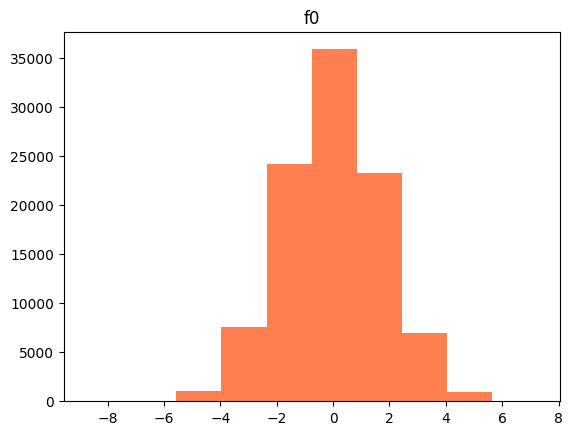

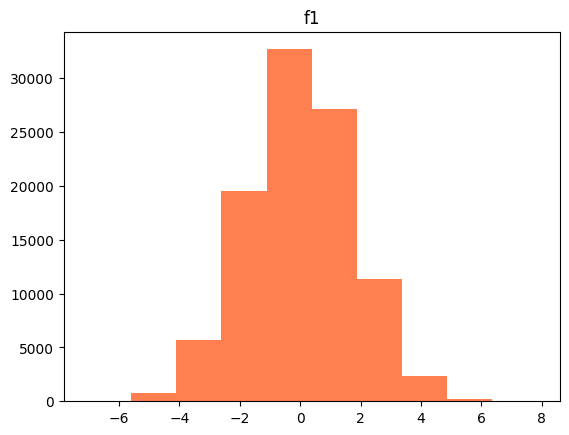

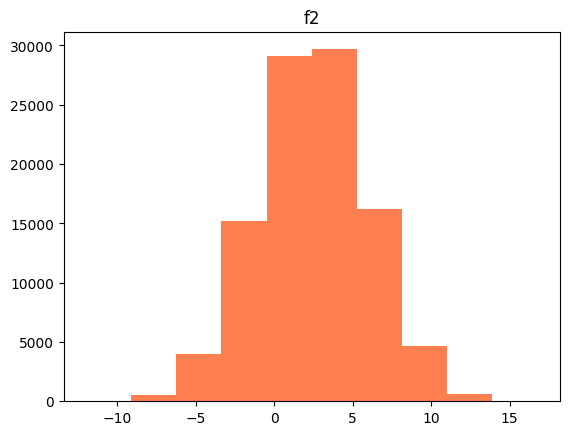

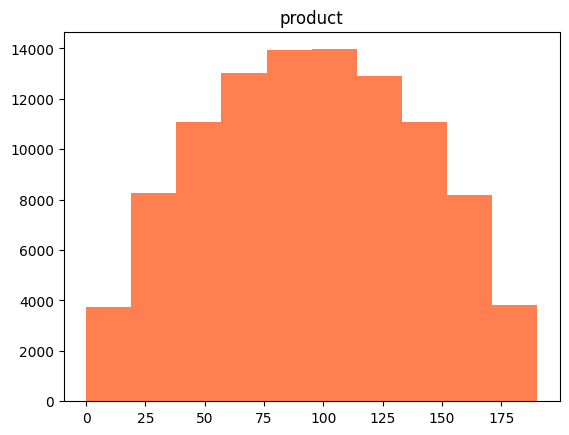

In [31]:
hist(geo_data2)

Во втором регионе целевой признак все признаки имеют нормальное распределение

## Обучение и проверка модели

### Тренировочная и валидационная выборка

In [32]:
geo_data0.shape

(99990, 4)

In [33]:
geo_data0_X = geo_data0.drop('product', axis=1)
geo_data0_y = geo_data0['product']

In [34]:
geo_data0_X_train, geo_data0_X_valid, geo_data0_y_train, geo_data0_y_valid = train_test_split(
    geo_data0_X, geo_data0_y, test_size=0.25, random_state=42
)

In [35]:
geo_data0_X_train.shape

(74992, 3)

In [36]:
geo_data1_X = geo_data1.drop('product', axis=1)
geo_data1_y = geo_data1['product']

In [37]:
geo_data1_X_train, geo_data1_X_valid, geo_data1_y_train, geo_data1_y_valid = train_test_split(
    geo_data1_X, geo_data1_y, test_size=0.25, random_state=42
)

In [38]:
geo_data2_X = geo_data2.drop('product', axis=1)
geo_data2_y = geo_data2['product']

In [39]:
geo_data2_X_train, geo_data2_X_valid, geo_data2_y_train, geo_data2_y_valid = train_test_split(
    geo_data2_X, geo_data2_y, test_size=0.25, random_state=42
)

### Обучение моделей

Задача представляет собой регрессию, следовательно, в качестве модели будем использовать линейную регрессию

In [40]:
geo_data0_model = LinearRegression()
geo_data0_model.fit(geo_data0_X_train, geo_data0_y_train)
geo_data0_pred = geo_data0_model.predict(geo_data0_X_valid)
geo_data0_pred = pd.DataFrame(geo_data0_pred, index=geo_data0_X_valid.index, columns=['pred'])

In [41]:
geo_data1_model = LinearRegression()
geo_data1_model.fit(geo_data1_X_train, geo_data1_y_train)
geo_data1_pred = geo_data1_model.predict(geo_data1_X_valid)
geo_data1_pred = pd.DataFrame(geo_data1_pred, index=geo_data1_X_valid.index, columns=['pred'])

In [42]:
geo_data2_model = LinearRegression()
geo_data2_model.fit(geo_data2_X_train, geo_data2_y_train)
geo_data2_pred = geo_data2_model.predict(geo_data2_X_valid)
geo_data2_pred = pd.DataFrame(geo_data2_pred, index=geo_data2_X_valid.index, columns=['pred'])

### Расчет метрики

Средний запас предсказанного сырья:

In [43]:
np.median(geo_data0_pred)

92.60230685934047

In [44]:
np.median(geo_data1_pred)

57.68860071603735

In [45]:
np.median(geo_data2_pred)

94.84131736856601

Метрика RMSE для каждой модели:

In [46]:
mean_squared_error(geo_data0_y_valid, geo_data0_pred, squared=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


37.68508926201444

In [47]:
mean_squared_error(geo_data1_y_valid, geo_data1_pred, squared=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.8928265978121416

In [48]:
mean_squared_error(geo_data2_y_valid, geo_data2_pred, squared=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


40.080822438088305

### Вывод

Обучили модель линейной регрессии. 

Сравнили средний запас предсказанного сырья - в первом регионе почти в два раза меньше, чем в остальных

Посчитали среднеквадратичную ошибку каждой модели:
1. 37.7
2. 0.89
3. 40.1

Первый регион имеет наиболее худшую точность модели

## Подготовка к расчёту прибыли

###  Ключевые значения 

In [49]:
REVENUE_PER_UNIT = 450000
BUDGET = 10 ** 10
WELLS = 200

Для каждого региона бюджет составляет 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. Посчитаем достаточный объём сырья для разработки новой скважины

### Достаточный объём сырья 

In [50]:
materials_amount = BUDGET / WELLS / REVENUE_PER_UNIT
print(f"Достаточный объем сырья в новой скважине: {materials_amount}")

Достаточный объем сырья в новой скважине: 111.11111111111111


### Сравнение

Ни в одном регионе средний запас предсказанного сырья не превышает достаточный объем. Следовательно, стоит выбирать наиболее прибыльные скважины 

## Расчёт прибыли и рисков 

### Функция для расчёта прибыли

In [51]:
def profit_calculation(data, pred):
    sorted_indices = pred.sort_values(by='pred', ascending=False).index[:200]
    data_sorted = data.loc[sorted_indices]
    
    volume_amount = data_sorted['product'].sum()
    revenue = volume_amount * REVENUE_PER_UNIT
    profit = revenue - BUDGET
    
    return profit

In [52]:
profit_data0 = profit_calculation(geo_data0, geo_data0_pred)
print(f'Прибыль с нулевого региона: {profit_data0:.2f}')

Прибыль с нулевого региона: 3468529787.42


In [53]:
profit_data1 = profit_calculation(geo_data1, geo_data1_pred)
print(f'Прибыль с первого региона: {profit_data1:.2f}')

Прибыль с первого региона: 2415086696.68


In [54]:
profit_data2 = profit_calculation(geo_data2, geo_data2_pred)
print(f'Прибыль со второго региона: {profit_data2:.2f}')

Прибыль со второго региона: 2396613000.94


### Bootstrap

In [55]:
def bootstrap(data, data_valid):
    values = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        subsample = data.sample(n=500, replace=True, random_state=state)
        profit = profit_calculation(data_valid, subsample)
        values.append(profit)
    values = pd.Series(values)
    
    mean_profit = values.mean()
    print(f'Средняя прибыль: {mean_profit:.2f}')
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print('Расчет 95% доверительного интервала:')
    print(f'Нижняя граница: {lower:.2f}')
    print(f'Верхняя граница: {upper:.2f}')

    risk_of_loss = (values < 0).mean()
    print(f'Риск убытков: {risk_of_loss}')

In [56]:
bootstrap(geo_data0_pred, geo_data0)

Средняя прибыль: 417354353.46
Расчет 95% доверительного интервала:
Нижняя граница: -96261928.02
Верхняя граница: 933493095.50
Риск убытков: 0.059


In [57]:
bootstrap(geo_data1_pred, geo_data1)

Средняя прибыль: 432017870.04
Расчет 95% доверительного интервала:
Нижняя граница: 51741836.33
Верхняя граница: 863042250.02
Риск убытков: 0.01


In [58]:
bootstrap(geo_data2_pred, geo_data2)

Средняя прибыль: 356881964.62
Расчет 95% доверительного интервала:
Нижняя граница: -186256154.76
Верхняя граница: 892099105.67
Риск убытков: 0.089


### Вывод

Наилучший регион для разработки скважин - первый, так как имеет наибольшую среднюю предсказанную прибыль - 432 млн и имеет наиболее прибыльный доверительный интервал. Также он обладает практически нулевым риском убытков - 0.01. 

Только первый регион имеет нижнюю границу прибыли меньше 0